# Notebook with main steps of Image analysis
- Build graph on the image
- Removing disrupted regions of the image and autofluorescent cells
- Selecting border and vessels

In [1]:
import numpy as np
import pandas
import networkx as nx
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statannot import add_stat_annotation
import glob
from tqdm.notebook import tqdm
from copy import copy
import tifffile

import napari
import griottes
import griottes.analyse
from griottes.graphmaker import make_spheroids
from griottes.graphmaker import graph_generation_func
from griottes.graphplotter import graph_plot
from scripts import plot_function
from coloriage import coloriage

## Eliminate bad regions and autofluorescent cells before further analysis
- For bad regions, we use Coloriage function to manually select the region to eliminate, save the results as .txt file and put it in 'cells_to_eliminate' folder
- For autofluorescent cells, a .txt file is created based on detection of these cells with neural network (trained_networks/Autofluo_trained_model_squeezenet) and put in 'cells_to_eliminate' folder

In [2]:
# Function to remove cells listed in .txt files present in 'cells_to_remove' folder
def remove_cells(fnames:list,
                 dataframe:pandas.DataFrame):
    for filename in fnames:
        SelectedData = pandas.read_csv(filename)
        labels = np.array(SelectedData[' cell_label'].unique())
        ind = np.array(dataframe.loc[dataframe['label'].isin(labels)].index)
        dataframe = dataframe.drop(ind)
    return dataframe

In [3]:
# Load data
FPATH = r'Example_image'
fname = '221212_6_classified.csv'
df_221212_6 = pandas.read_csv(os.path.join(FPATH, fname))

In [4]:
# Create graph from the dataset using Griottes to be able to manually select regions to eliminate with Coloriage

# Attributes to nodes in the graph
descriptors = ['label', 'cell_type', 'color', 'legend','cell_properties','x', 'y', 'z']

# Attribute a color to the nodes
n_colors = len(df_221212_6.cell_type.unique())
color_list = [plt.cm.Set1(i) for i in range(n_colors)]
colors = [color_list[df_221212_6.loc[i, 'cell_type']] for i in range(len(df_221212_6))]
df_221212_6['color'] = colors

# Put z to 0 as it is a 2D image
df_221212_6['z'] = 0

G_221212_6 = graph_generation_func.generate_delaunay_graph(df_221212_6,
                                                  image_is_2D = True,
                                                  descriptors = descriptors,
                                                  distance = 100)

In [ ]:
# Use coloriage graphical interface in jupyter notebook to select and save regions to remove on the image
# Place the select .txt file in a folder called cells_to_remove with autofluorescent cells
coloriage.make_interactive_plot(G_221212_6, plot_width = 1500, plot_height = 1500)

In [5]:
FPATH = r'Example_image'
files_to_remove = glob.glob(os.path.join(FPATH, 'cells_to_remove/*'))
dft_221212_6 = remove_cells(files_to_remove, df_221212_6)
dft_221212_6['date'] = '221212_6'

In [6]:
# Create a new graph after removing cells
descriptors = ['label', 'cell_type', 'color', 'legend','cell_properties','x', 'y', 'z']
Gt_221212_6 = graph_generation_func.generate_delaunay_graph(dft_221212_6,
                                                  image_is_2D = True,
                                                  descriptors = descriptors,
                                                  distance = 100)

## Dot plot with each cell type before and after undesired cells elimination

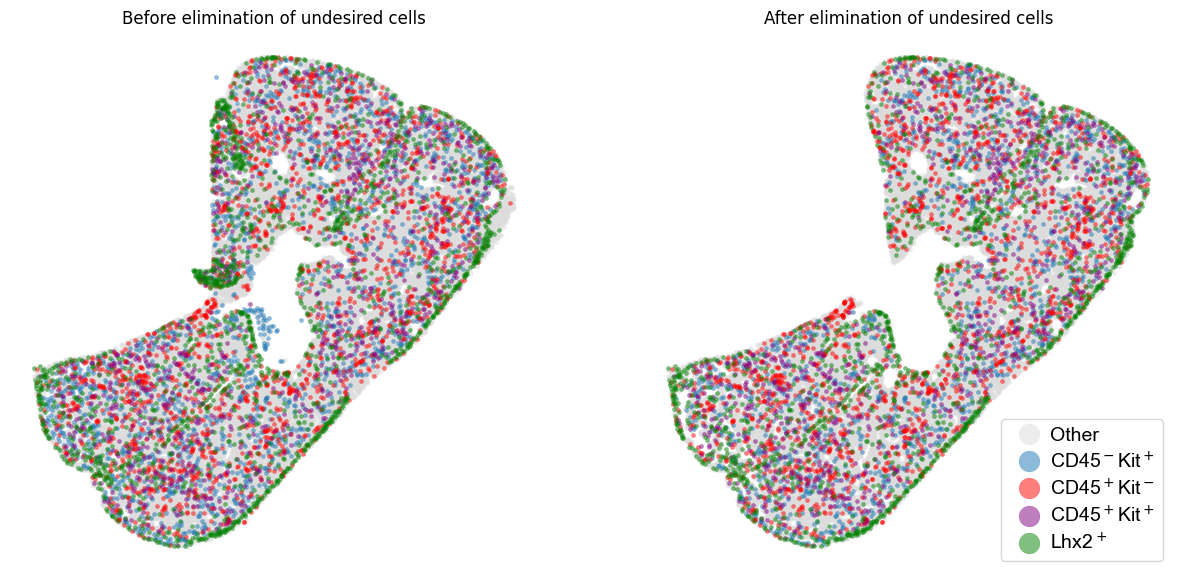

In [7]:
# Plot the result before and after removing cells
# Each cell type is plotted separately to customize colors for each cell type

fig, ax = plt.subplots(1,2, figsize=(15,7))

node_list = []
for x, y in G_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45-, Kit-, Lhx2-'):
        node_list.append(x)
cell_type_1 = G_221212_6.subgraph(node_list)
node_list = []
for x, y in G_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45-, Kit+, Lhx2-'):
        node_list.append(x)
cell_type_2 = G_221212_6.subgraph(node_list)
node_list = []
for x, y in G_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45+, Kit-, Lhx2-'):
        node_list.append(x)
cell_type_3 = G_221212_6.subgraph(node_list)
node_list = []
for x, y in G_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45+, Kit+, Lhx2-'):
        node_list.append(x)
cell_type_4 = G_221212_6.subgraph(node_list)
node_list = []
for x, y in G_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45-, Kit-, Lhx2+'):
        node_list.append(x)
cell_type_5 = G_221212_6.subgraph(node_list)

plot_function.network_plot_2D(
    cell_type_1,
    ax[0],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'gainsboro',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'gainsboro')

plot_function.network_plot_2D(
    cell_type_2,
    ax[0],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'tab:blue',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'tab:blue')

plot_function.network_plot_2D(
    cell_type_3,
    ax[0],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'red',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'red')

plot_function.network_plot_2D(
    cell_type_4,
    ax[0],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'purple',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'purple')

plot_function.network_plot_2D(
    cell_type_5,
    ax[0],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'green',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'green')

node_list = []
for x, y in Gt_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45-, Kit-, Lhx2-'):
        node_list.append(x)
cell_type_1 = Gt_221212_6.subgraph(node_list)
node_list = []
for x, y in Gt_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45-, Kit+, Lhx2-'):
        node_list.append(x)
cell_type_2 = Gt_221212_6.subgraph(node_list)
node_list = []
for x, y in Gt_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45+, Kit-, Lhx2-'):
        node_list.append(x)
cell_type_3 = Gt_221212_6.subgraph(node_list)
node_list = []
for x, y in Gt_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45+, Kit+, Lhx2-'):
        node_list.append(x)
cell_type_4 = Gt_221212_6.subgraph(node_list)
node_list = []
for x, y in Gt_221212_6.nodes(data = True):
    if (y['cell_properties'] == 'CD45-, Kit-, Lhx2+'):
        node_list.append(x)
cell_type_5 = Gt_221212_6.subgraph(node_list)

plot_function.network_plot_2D(
    cell_type_1,
    ax[1],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'gainsboro',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'gainsboro')

plot_function.network_plot_2D(
    cell_type_2,
    ax[1],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'tab:blue',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'tab:blue')

plot_function.network_plot_2D(
    cell_type_3,
    ax[1],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'red',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'red')

plot_function.network_plot_2D(
    cell_type_4,
    ax[1],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'purple',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'purple')

plot_function.network_plot_2D(
    cell_type_5,
    ax[1],
    plot_connections = False,
    alpha_line=0.6,
    alpha = 0.5,
    scatterpoint_size=3,
    legend=True,
    weights=False,
    edge_color="k",
    line_factor=1,
    legend_fontsize=10,
    marker_edge_color = 'green',
    marker_shape = 'o',
    marker_edge_width = 0.25,
    marker_face_color = 'green')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].get_legend().remove()
ax[0].set_title("Before elimination of undesired cells")

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].set_title("After elimination of undesired cells")

plt.rc('font',family='Arial')
labels = ['Other', 'CD45$^-$Kit$^+$', 'CD45$^+$Kit$^-$', 'CD45$^+$Kit$^+$', 'Lhx2$^+$']
ax[1].legend(labels, loc='lower right', borderpad=0.4, labelspacing=0.3, handletextpad=0.1, markerscale = 5, fontsize=14, columnspacing=0)
plt.show()

In [31]:
# Save result in a table
dft_221212_6.to_csv(r'Example_image/221212_6_classified_corrected.csv', index = False)

## Check classification using Napari
- Open a napari viewer
- Drag and drop the image inside (the order of channels is different than with fiji so use the file called 'Example_image/221212_6_napari.tif') / use Griottes reader so the channels will be automatically splitted
- Adjust intensity in each channel to see better contrasts and select blending>additive to be able to see the dots coming from segmentation on top of the image
- Add point layer 

In [38]:
# Open napari viewer
v = napari.Viewer()

Opening Z:\Marcia_Valentin\All\Data_and_code_paper\Image_processing\Example_image\221212_6_napari.tif
input shape: (14962, 13913, 4)
transpose -> (4, 14962, 13913)


Drag and drop the image inside (the order of channels is different than with fiji so use the file called 'Example_image/221212_6_napari.tif') / use Griottes reader so the channels will be automatically splitted

In [39]:
# Load data
data = pandas.read_csv('Example_image/221212_6_classified_corrected.csv', delimiter = ',')
data = data.sort_values(by = 'cell_type')

# Correspondance cell type number / cell phenotype
print(0, data.loc[data.cell_type == 0, 'cell_properties'].unique())
print(1, data.loc[data.cell_type == 1, 'cell_properties'].unique())
print(2, data.loc[data.cell_type == 2, 'cell_properties'].unique())
print(3, data.loc[data.cell_type == 3, 'cell_properties'].unique())
print(4, data.loc[data.cell_type == 4, 'cell_properties'].unique())

0 ['CD45+, Kit+, Lhx2-']
1 ['CD45+, Kit-, Lhx2-']
2 ['CD45-, Kit+, Lhx2-']
3 ['CD45-, Kit-, Lhx2+']
4 ['CD45-, Kit-, Lhx2-']


In [40]:
# Add point layer on napari viewer
points = np.array(data[['y', 'x']])
point_properties = {'cell_type': np.array(data['cell_type'])}

point_properties = {
    'label': np.array(data['label']),
    'cell_type': np.array(data['cell_type']),
    'cell_properties': np.array(data['cell_properties']),
}

points_layer = v.add_points(
    points,
    ndim = 2,
    size = 10,
    edge_width=0,
    properties=point_properties,
    face_color='cell_type',
    face_color_cycle = ['purple', 'red', 'blue', 'green', 'white']
)

In [41]:
# Add bar scale on the viewer (Optionnal)
for i in range(len(v.layers)):
    layer = v.layers[i]
    layer.scale = [0.25, 0.25]
    
v.scale_bar.visible = True
v.scale_bar.font_size  = 20
v.scale_bar.position = 'bottom_right'
v.scale_bar.unit = "µm"

## Global tissue composition

In [8]:
# Function to get tissue composition
def get_ratio_composition(tissue_data):
    ratio_composition = pandas.DataFrame()
    i = 0
    for date in tissue_data.date.unique():
        global_properties = tissue_data[tissue_data.date == date]
        value_counts_global = global_properties['cell_properties'].value_counts()
        value_counts_global_ratio = value_counts_global/value_counts_global.values.sum()
        for ind in value_counts_global_ratio.index:
            ratio_composition.loc[i, 'cell_properties'] = ind
            ratio_composition.loc[i, 'fraction'] = value_counts_global_ratio[ind]
            ratio_composition.loc[i, 'date'] = date
            i += 1
    return ratio_composition

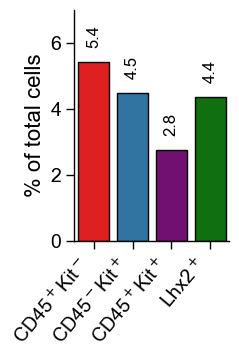

In [9]:
# Calculate cell type's frequency 
ratio_composition_221212_6 = get_ratio_composition(dft_221212_6)
ratio_composition_221212_6['composition'] = 100*ratio_composition_221212_6['fraction']

# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(figsize = (2,3))

order = ['CD45+, Kit-, Lhx2-', 'CD45-, Kit+, Lhx2-', 'CD45+, Kit+, Lhx2-', 'CD45-, Kit-, Lhx2+']

ax = sns.barplot(x="cell_properties", 
                 y="composition",
                 data=ratio_composition_221212_6,
                 order=order,
                 palette = ['red', 'tab:blue', 'purple', 'green'],
                 errorbar='sd',
                 errcolor='black',
                 capsize=0.2,
                 errwidth=1,
                 color = 'r',
                 lw = 1, 
                 edgecolor="0")
ax.set_ylim(top=7)

# Add corresponding value to each bar
ax.bar_label(ax.containers[0], fmt='%.1f', fontsize = 12, padding = 10, rotation=90)

# Remove the square around the graph and plot only x and y axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Define axis parameters
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1) 
ax.tick_params(width=1, length=6)
ax.set_ylabel('% of total cells', fontsize = 16)
ax.set_xlabel('')

# Add labels of x axis with subscripts
ticklabels = ['CD45$^+$Kit$^-$', 'CD45$^-$Kit$^+$', 'CD45$^+$Kit$^+$', 'Lhx2$^+$']
ax.set_xticklabels(
                    # ax.get_xticklabels(),
                    ticklabels,
                    rotation=50,
                    horizontalalignment='right',
                    verticalalignment = 'top')
plt.show()

## Calculate distance to border and central vessel

### Select border and central vessels
- Use again Coloriage function to select border cells of the tissue and vessels
- Save .txt files and put them in folders called respectively 'boder_selection' and 'vessels_selection'

In [ ]:
coloriage.make_interactive_plot(Gt_221212_6, plot_width = 1500, plot_height = 1500)

### Compute minimum distance to border and Ductus venosous (DV)

In [10]:
# Put a marker for cells selected as border or DV of the tissue

def mark_border_cells(fnames:list,
                      dataframe:pandas.DataFrame):
    for filename in fnames:
        SelectedData = pandas.read_csv(filename)
        labels = np.array(SelectedData[' cell_label'].unique())
        dataframe.loc[dataframe['label'].isin(labels), 'border'] = 1
    return dataframe

def mark_vessel_cells(fnames:list,
                      dataframe:pandas.DataFrame):
    for filename in fnames:
        SelectedData = pandas.read_csv(filename)
        labels = np.array(SelectedData[' cell_label'].unique())
        dataframe.loc[dataframe['label'].isin(labels), 'vessel'] = 1
    return dataframe

# Get minimum distance to the border of the tissue for each cell

def get_distance(dataframe):
    border_cells = dataframe[dataframe.border == 1]
    for ind in tqdm(dataframe.index):
        x_cell = dataframe.loc[ind, 'x']
        y_cell = dataframe.loc[ind, 'y']
        dist = np.sqrt((border_cells.x - x_cell)**2+(border_cells.y - y_cell)**2)
        min_dist = np.min(dist)
        dataframe.loc[ind, 'min_dist'] = min_dist
    return dataframe

# Get minimum distance to the DV for each cell

def get_distance_vessel(dataframe):
    vessel_cells = dataframe[dataframe.vessel == 1]
    for ind in tqdm(dataframe.index):
        x_cell = dataframe.loc[ind, 'x']
        y_cell = dataframe.loc[ind, 'y']
        dist = np.sqrt((vessel_cells.x - x_cell)**2+(vessel_cells.y - y_cell)**2)
        min_dist = np.min(dist)
        dataframe.loc[ind, 'min_dist'] = min_dist
    return dataframe

In [11]:
# Compute minimal distance to a border cell
FPATH = r'Example_image'
border_selection = glob.glob(os.path.join(FPATH, 'border_selection/*'))
dft_221212_6 = mark_border_cells(border_selection, dft_221212_6)
distance_221212_6 = dft_221212_6.copy()
distance_221212_6 = get_distance(distance_221212_6)

# Compute minimal distance to a DV
FPATH = r'Example_image'
vessels_selection = glob.glob(os.path.join(FPATH, 'vessels_selection/*'))
dft_221212_6 = mark_vessel_cells(vessels_selection, dft_221212_6)
distance_vessel_221212_6 = dft_221212_6.copy()
distance_vessel_221212_6 = get_distance_vessel(distance_vessel_221212_6)

  0%|          | 0/33030 [00:00<?, ?it/s]

  0%|          | 0/33030 [00:00<?, ?it/s]

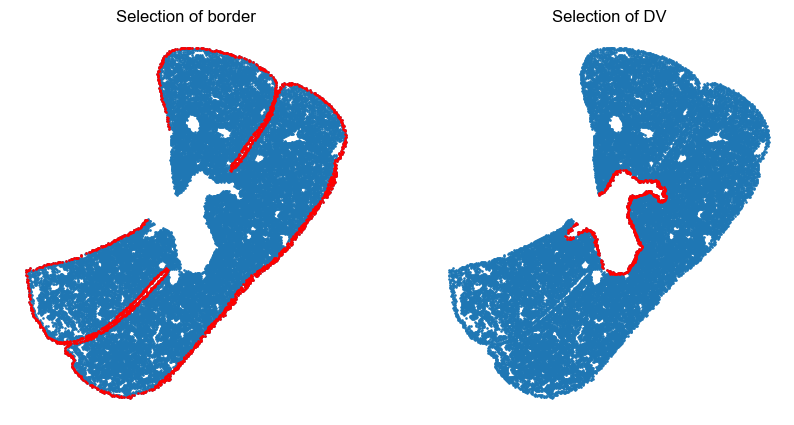

In [12]:
fig, axes = plt.subplots(1,2,figsize = (10,5))

axes[0].scatter(distance_221212_6.x, distance_221212_6.y, s = 0.8)
axes[0].scatter(distance_221212_6.loc[distance_221212_6.border == 1, 'x'],
                distance_221212_6.loc[distance_221212_6.border == 1, 'y'],
                color = 'r', s = 0.8)

axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].set_title('Selection of border')

axes[1].scatter(distance_vessel_221212_6.x, distance_vessel_221212_6.y, s = 0.8)
axes[1].scatter(distance_vessel_221212_6.loc[distance_vessel_221212_6.vessel == 1, 'x'],
                distance_vessel_221212_6.loc[distance_vessel_221212_6.vessel == 1, 'y'],
                color = 'r', s = 0.8)

axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].set_title('Selection of DV')
plt.show()

### Compute composition of cells at given distance to border or vessels

In [13]:
def compute_progenitor_distance_stats(df, date):
    
    assert 'cell_properties_CD45' in df.columns
    assert 'cell_properties_Kit' in df.columns
    assert 'cell_properties_Lhx2' in df.columns

    # Make cell properties
    df.cell_properties = df.cell_properties_CD45 + ', ' +  df.cell_properties_Kit + ', ' + df.cell_properties_Lhx2
    
    df['CD45- Kit- Lhx2-'] = 0
    df['CD45- Kit+ Lhx2-'] = 0
    df['CD45+ Kit- Lhx2-'] = 0
    df['CD45+ Kit+ Lhx2-'] = 0
    df['CD45- Kit- Lhx2+'] = 0
    df['date'] = date

    df.loc[df.cell_properties == 'CD45-, Kit-, Lhx2-', 'CD45- Kit- Lhx2-'] = 100
    df.loc[df.cell_properties == 'CD45-, Kit+, Lhx2-', 'CD45- Kit+ Lhx2-'] = 100
    df.loc[df.cell_properties == 'CD45+, Kit-, Lhx2-', 'CD45+ Kit- Lhx2-'] = 100
    df.loc[df.cell_properties == 'CD45+, Kit+, Lhx2-', 'CD45+ Kit+ Lhx2-'] = 100
    df.loc[df.cell_properties == 'CD45-, Kit-, Lhx2+', 'CD45- Kit- Lhx2+'] = 100

    df['distance_avge'] = df.min_dist
    df['distance_avge_mu'] = 0.18*df['distance_avge'] # Conversion pixel to µm

    return df

In [14]:
distance_221212_6 = compute_progenitor_distance_stats(distance_221212_6, date = '221212_6')
distance_vessel_221212_6 = compute_progenitor_distance_stats(distance_vessel_221212_6, date = '221212_6')

In [15]:
# Compute percentage of total cells at given distance to border or vessels for each cell phenotype and smooth curves (rolling average)

def rolling_average(df,
                    dist_col,
                    col,
                    L):
    signalframe = pandas.DataFrame()
    i = 0 
    minx = df[dist_col].min()
    maxx = df[dist_col].max()
    for x in np.arange(minx, maxx):
        signalframe.loc[x, 'mean'] = df.loc[(df[dist_col]+L/2 > x) & (df[dist_col]-L/2 < x), col].mean()
        signalframe.loc[x, 'std'] = df.loc[(df[dist_col]+L/2 > x) & (df[dist_col]-L/2 < x), col].std()
        signalframe.loc[x, 'n'] = len(df.loc[(df[dist_col]+L/2 > x) & (df[dist_col]-L/2 < x), col])
    return signalframe

def distance_distributions(df,
                           cell_type,
                           L = 50):
    smooth_frame = pandas.DataFrame()
    for date in df.date.unique():
        bio_frame = df[df.date == date]
        mean_composition = bio_frame[cell_type].mean()
        bio_frame_composition = rolling_average(bio_frame,
                                          'distance_avge_mu',
                                          cell_type,
                                          L)
        bio_frame_composition['mean_smooth'] = bio_frame_composition['mean'].rolling(20).mean().shift(-10)
        bio_frame_composition['mean_normalized'] = bio_frame_composition['mean']/mean_composition
        bio_frame_composition['mean_normalized_smooth'] = bio_frame_composition['mean_normalized'].rolling(20).mean().shift(-10)
        bio_frame_composition['r'] = bio_frame_composition.index
        bio_frame_composition['date'] = date
        smooth_frame = pandas.concat([smooth_frame, bio_frame_composition])
    return smooth_frame

### We compare distance to structure vs random distribution of cells, keeping the same tissue composition

In [16]:
selected_columns = ['label', 'x', 'y', 'cell_properties', 'cell_type', 'color', 'legend', 'date', 'border', 'min_dist',
                    'CD45- Kit- Lhx2-', 'CD45- Kit+ Lhx2-', 'CD45+ Kit- Lhx2-', 'CD45+ Kit+ Lhx2-', 'CD45- Kit- Lhx2+', 'distance_avge', 'distance_avge_mu']

columns_to_shuffle = ['cell_properties', 'cell_type', 'color', 'legend', 'CD45- Kit- Lhx2-', 'CD45- Kit+ Lhx2-', 'CD45+ Kit- Lhx2-', 'CD45+ Kit+ Lhx2-', 'CD45- Kit- Lhx2+']

In [17]:
# Select only columns of interest
distance_221212_6 = distance_221212_6[selected_columns]

### Distance to border and DV of CD45$^+$Kit$^-$ cells

In [18]:
# Compute composition of the tissue at a given distance to the border in terms of CD45+/Kit-/Lhx2- cells if the cells were randomly distributed (10 repetitions)

CD45_evo_random = pandas.DataFrame()
for i in tqdm([q for q in range(10)]):
    distance_data_random = copy(distance_221212_6)
    distance_data_random[columns_to_shuffle] = distance_221212_6[columns_to_shuffle].sample(frac = 1).reset_index().drop('index', axis=1)
    cell_type = 'CD45+ Kit- Lhx2-'
    CD45_evo = distance_distributions(distance_data_random, cell_type)
    CD45_evo = CD45_evo.reset_index()
    CD45_evo['repetition'] = i
    CD45_evo_random = pandas.concat([CD45_evo_random, CD45_evo])
CD45_evo_random = CD45_evo_random.reset_index()
    
# Compute composition of the tissue at a given distance to DV in terms of CD45+/Kit-/Lhx2- cells if the cells were randomly distributed (10 repetitions)

CD45_evo_vessel_random = pandas.DataFrame()
for i in tqdm([q for q in range(10)]):
    distance_data_random = copy(distance_vessel_221212_6)
    distance_data_random[columns_to_shuffle] = distance_vessel_221212_6[columns_to_shuffle].sample(frac = 1).reset_index().drop('index', axis=1)
    cell_type = 'CD45+ Kit- Lhx2-'
    CD45_evo_vessel = distance_distributions(distance_data_random, cell_type)
    CD45_evo_vessel = CD45_evo_vessel.reset_index()
    CD45_evo_vessel['repetition'] = i
    CD45_evo_vessel_random = pandas.concat([CD45_evo_vessel_random, CD45_evo_vessel])
CD45_evo_vessel_random = CD45_evo_vessel_random.reset_index()

# Compute observed composition of the tissue at a given distance to the border in terms of CD45+/Kit-/Lhx2- cells

CD45_evo = distance_distributions(distance_221212_6, 'CD45+ Kit- Lhx2-')
CD45_evo = CD45_evo.reset_index()

# Compute observed composition of the tissue at a given distance to DV in terms of CD45+/Kit-/Lhx2- cells

CD45_evo_vessel = distance_distributions(distance_vessel_221212_6, 'CD45+ Kit- Lhx2-')
CD45_evo_vessel = CD45_evo_vessel.reset_index()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

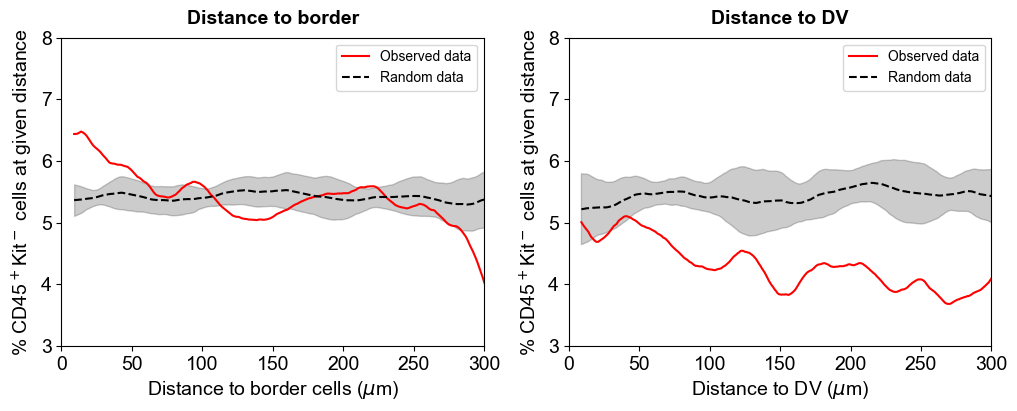

In [19]:
plt.rc('font',family='Arial')

fig, ax = plt.subplots(1, 2, figsize = (12,4))

ax1 = sns.lineplot(data = CD45_evo, x = 'r', y = 'mean_smooth', ax=ax[0], color = 'red', label = 'Observed data')

ax1 = sns.lineplot(data = CD45_evo_random,
                   x = 'r',
                   y = 'mean_smooth',
                   linestyle='--',
                   errorbar = 'sd',
                   label = 'Random data',
                   ax=ax[0],
                   color = 'k')

ax2 = sns.lineplot(data = CD45_evo_vessel, x = 'r', y = 'mean_smooth', ax=ax[1], color = 'red', label = 'Observed data') 
ax2 = sns.lineplot(data = CD45_evo_vessel_random, 
                   x = 'r',
                   y = 'mean_smooth',
                   linestyle='--',
                   errorbar = 'sd',
                   label = 'Random data',
                   ax=ax[1],
                   color = 'k')

for x in range(2):
    ax[x].set_ylim(3,8)
    ax[x].set_xlim(0,300)
    ax[x].tick_params(axis='y', labelsize=14, colors='k')
    ax[x].tick_params(axis='x', labelsize=14, colors='black')
    ax[x].set_ylabel('% CD45$^+$Kit$^-$ cells at given distance', fontsize = 14, c = 'k')

ax1.set_xlabel('Distance to border cells ($\mu$m)', fontsize = 14)
ax2.set_xlabel('Distance to DV ($\mu$m)', fontsize = 14)

ax1.set_title('Distance to border', fontsize = 14, pad = 10, loc='center', weight='bold')
ax2.set_title('Distance to DV', fontsize = 14, pad = 10, loc='center', weight='bold')

plt.show()

### Distance to border and DV of CD45$^-$Kit$^+$ cells

In [20]:
# Compute composition of the tissue at a given distance to the border in terms of CD45-/Kit+/Lhx2- cells if the cells were randomly distributed (10 repetitions)

Kit_evo_random = pandas.DataFrame()
for i in tqdm([q for q in range(20)]):
    distance_data_random = copy(distance_221212_6)
    distance_data_random[columns_to_shuffle] = distance_221212_6[columns_to_shuffle].sample(frac = 1).reset_index().drop('index', axis=1)
    cell_type = 'CD45- Kit+ Lhx2-'
    Kit_evo = distance_distributions(distance_data_random, cell_type)
    Kit_evo = Kit_evo.reset_index()
    Kit_evo['repetition'] = i
    Kit_evo_random = pandas.concat([Kit_evo_random, Kit_evo])
Kit_evo_random = Kit_evo_random.reset_index()  

# Compute composition of the tissue at a given distance to DV in terms of CD45-/Kit+/Lhx2- cells if the cells were randomly distributed (10 repetitions)

Kit_evo_vessel_random = pandas.DataFrame()
for i in tqdm([q for q in range(20)]):
    distance_data_random = copy(distance_vessel_221212_6)
    distance_data_random[columns_to_shuffle] = distance_vessel_221212_6[columns_to_shuffle].sample(frac = 1).reset_index().drop('index', axis=1)
    cell_type = 'CD45- Kit+ Lhx2-'
    Kit_evo_vessel = distance_distributions(distance_data_random, cell_type)
    Kit_evo_vessel = Kit_evo_vessel.reset_index()
    Kit_evo_vessel['repetition'] = i
    Kit_evo_vessel_random = pandas.concat([Kit_evo_vessel_random, Kit_evo_vessel])
Kit_evo_vessel_random = Kit_evo_vessel_random.reset_index()

# Compute observed composition of the tissue at a given distance to the border in terms of CD45-/Kit+/Lhx2- cells

Kit_evo = distance_distributions(distance_221212_6, 'CD45- Kit+ Lhx2-')
Kit_evo = Kit_evo.reset_index()

# Compute observed composition of the tissue at a given distance to DV in terms of CD45-/Kit+/Lhx2- cells

Kit_evo_vessel = distance_distributions(distance_vessel_221212_6, 'CD45- Kit+ Lhx2-')
Kit_evo_vessel = Kit_evo_vessel.reset_index()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

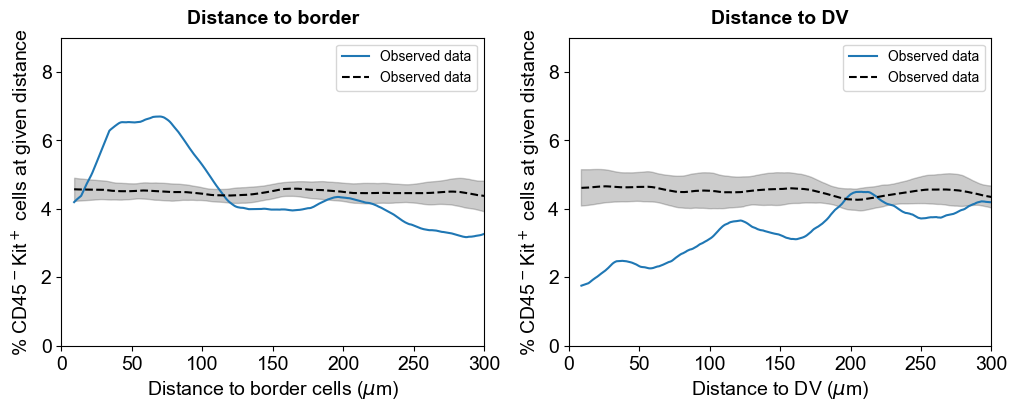

In [21]:
plt.rc('font',family='Arial')

fig, ax = plt.subplots(1, 2, figsize = (12,4))

ax1 = sns.lineplot(data = Kit_evo, x = 'r', y = 'mean_smooth', ax=ax[0], color = 'tab:blue', label = 'Observed data')

ax1 = sns.lineplot(data = Kit_evo_random,
                   x = 'r',
                   y = 'mean_smooth',
                   linestyle='--',
                   errorbar = 'sd',
                   label = 'Observed data',
                   ax=ax[0],
                   color = 'k')

ax2 = sns.lineplot(data = Kit_evo_vessel, x = 'r', y = 'mean_smooth', ax=ax[1], color = 'tab:blue', label = 'Observed data') 
ax2 = sns.lineplot(data = Kit_evo_vessel_random, 
                   x = 'r',
                   y = 'mean_smooth',
                   linestyle='--',
                   errorbar = 'sd',
                   label = 'Observed data',
                   ax=ax[1],
                   color = 'k')

for x in range(2):
    ax[x].set_ylim(0,9)
    ax[x].set_xlim(0,300)
    ax[x].tick_params(axis='y', labelsize=14, colors='k')
    ax[x].tick_params(axis='x', labelsize=14, colors='black')
    ax[x].set_ylabel('% CD45$^-$Kit$^+$ cells at given distance', fontsize = 14, c = 'k')

ax1.set_xlabel('Distance to border cells ($\mu$m)', fontsize = 14)
ax2.set_xlabel('Distance to DV ($\mu$m)', fontsize = 14)

ax1.set_title('Distance to border', fontsize = 14, pad = 10, loc='center', weight='bold')
ax2.set_title('Distance to DV', fontsize = 14, pad = 10, loc='center', weight='bold')
plt.show()

### Distance to border and DV of CD45$^+$Kit$^+$ cells

In [22]:
# Compute composition of the tissue at a given distance to the border in terms of CD45+/Kit+/Lhx2- cells if the cells were randomly distributed (10 repetitions)
CD45_Kit_evo_random = pandas.DataFrame()
for i in tqdm([q for q in range(20)]):
    distance_data_random = copy(distance_221212_6)
    distance_data_random[columns_to_shuffle] = distance_221212_6[columns_to_shuffle].sample(frac = 1).reset_index().drop('index', axis=1)
    cell_type = 'CD45+ Kit+ Lhx2-'
    CD45_Kit_evo = distance_distributions(distance_data_random, cell_type)
    CD45_Kit_evo = CD45_Kit_evo.reset_index()
    CD45_Kit_evo['repetition'] = i
    CD45_Kit_evo_random = pandas.concat([CD45_Kit_evo_random, CD45_Kit_evo])
CD45_Kit_evo_random = CD45_Kit_evo_random.reset_index()

# Compute composition of the tissue at a given distance to DV in terms of CD45+/Kit+/Lhx2- cells if the cells were randomly distributed (10 repetitions)
CD45_Kit_evo_vessel_random = pandas.DataFrame()
for i in tqdm([q for q in range(20)]):
    distance_data_random = copy(distance_vessel_221212_6)
    distance_data_random[columns_to_shuffle] = distance_vessel_221212_6[columns_to_shuffle].sample(frac = 1).reset_index().drop('index', axis=1)
    cell_type = 'CD45+ Kit+ Lhx2-'
    CD45_Kit_evo_vessel = distance_distributions(distance_data_random, cell_type)
    CD45_Kit_evo_vessel = CD45_Kit_evo_vessel.reset_index()
    CD45_Kit_evo_vessel['repetition'] = i
    CD45_Kit_evo_vessel_random = pandas.concat([CD45_Kit_evo_vessel_random, CD45_Kit_evo_vessel])
CD45_Kit_evo_vessel_random = CD45_Kit_evo_vessel_random.reset_index()

# Compute observed composition of the tissue at a given distance to the border in terms of CD45+/Kit+/Lhx2- cells
CD45_Kit_evo = distance_distributions(distance_221212_6, 'CD45+ Kit+ Lhx2-')
CD45_Kit_evo = CD45_Kit_evo.reset_index()

# Compute observed composition of the tissue at a given distance to DV in terms of CD45+/Kit+/Lhx2- cells
CD45_Kit_evo_vessel = distance_distributions(distance_vessel_221212_6, 'CD45+ Kit+ Lhx2-')
CD45_Kit_evo_vessel = CD45_Kit_evo_vessel.reset_index()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

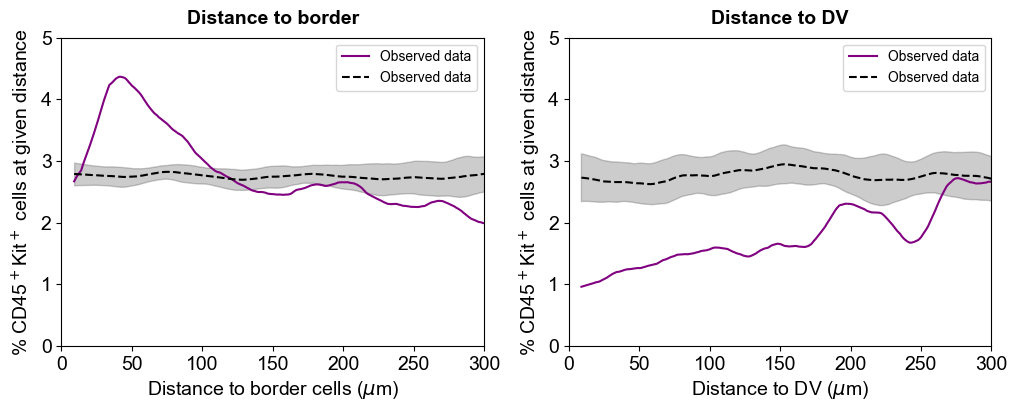

In [23]:
plt.rc('font',family='Arial')

fig, ax = plt.subplots(1, 2, figsize = (12,4))

ax1 = sns.lineplot(data = CD45_Kit_evo, x = 'r', y = 'mean_smooth', ax=ax[0], color = 'purple', label = 'Observed data')

ax1 = sns.lineplot(data = CD45_Kit_evo_random,
                   x = 'r',
                   y = 'mean_smooth',
                   linestyle='--',
                   errorbar = 'sd',
                   label = 'Observed data',
                   ax=ax[0],
                   color = 'k')

ax2 = sns.lineplot(data = CD45_Kit_evo_vessel, x = 'r', y = 'mean_smooth', ax=ax[1], color = 'purple', label = 'Observed data') 
ax2 = sns.lineplot(data = CD45_Kit_evo_vessel_random, 
                   x = 'r',
                   y = 'mean_smooth',
                   linestyle='--',
                   errorbar = 'sd',
                   label = 'Observed data',
                   ax=ax[1],
                   color = 'k')

for x in range(2):
    ax[x].set_ylim(0,5)
    ax[x].set_xlim(0,300)
    ax[x].tick_params(axis='y', labelsize=14, colors='k')
    ax[x].tick_params(axis='x', labelsize=14, colors='black')
    ax[x].set_ylabel('% CD45$^+$Kit$^+$ cells at given distance', fontsize = 14, c = 'k')

ax1.set_xlabel('Distance to border cells ($\mu$m)', fontsize = 14)
ax2.set_xlabel('Distance to DV ($\mu$m)', fontsize = 14)

ax1.set_title('Distance to border', fontsize = 14, pad = 10, loc='center', weight='bold')
ax2.set_title('Distance to DV', fontsize = 14, pad = 10, loc='center', weight='bold')
plt.show()

### Distance to border and DV of Lhx2$^+$ cells

In [24]:
# Compute composition of the tissue at a given distance to the border in terms of CD45-/Kit-/Lhx2+ cells if the cells were randomly distributed (10 repetitions)
Lhx2_evo_random = pandas.DataFrame()
for i in tqdm([q for q in range(20)]):
    distance_data_random = copy(distance_221212_6)
    distance_data_random[columns_to_shuffle] = distance_221212_6[columns_to_shuffle].sample(frac = 1).reset_index().drop('index', axis=1)
    cell_type = 'CD45- Kit- Lhx2+'
    Lhx2_evo = distance_distributions(distance_data_random, cell_type)
    Lhx2_evo = Lhx2_evo.reset_index()
    Lhx2_evo['repetition'] = i
    Lhx2_evo_random = pandas.concat([Lhx2_evo_random, Lhx2_evo])
Lhx2_evo_random = Lhx2_evo_random.reset_index()

# Compute composition of the tissue at a given distance to DV in terms of CD45-/Kit-/Lhx2+ cells if the cells were randomly distributed (10 repetitions)
Lhx2_evo_vessel_random = pandas.DataFrame()
for i in tqdm([q for q in range(20)]):
    distance_data_random = copy(distance_vessel_221212_6)
    distance_data_random[columns_to_shuffle] = distance_vessel_221212_6[columns_to_shuffle].sample(frac = 1).reset_index().drop('index', axis=1)
    cell_type = 'CD45- Kit- Lhx2+'
    Lhx2_evo_vessel = distance_distributions(distance_data_random, cell_type)
    Lhx2_evo_vessel = Lhx2_evo_vessel.reset_index()
    Lhx2_evo_vessel['repetition'] = i
    
    Lhx2_evo_vessel_random = pandas.concat([Lhx2_evo_vessel_random, Lhx2_evo_vessel])
Lhx2_evo_vessel_random = Lhx2_evo_vessel_random.reset_index()

# Compute observed composition of the tissue at a given distance to the border in terms of CD45-/Kit-/Lhx2+ cells
Lhx2_evo = distance_distributions(distance_221212_6, 'CD45- Kit- Lhx2+')
Lhx2_evo = Lhx2_evo.reset_index()

# Compute observed composition of the tissue at a given distance to DV in terms of CD45-/Kit-/Lhx2+ cells
Lhx2_evo_vessel = distance_distributions(distance_vessel_221212_6, 'CD45- Kit- Lhx2+')
Lhx2_evo_vessel = Lhx2_evo_vessel.reset_index()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

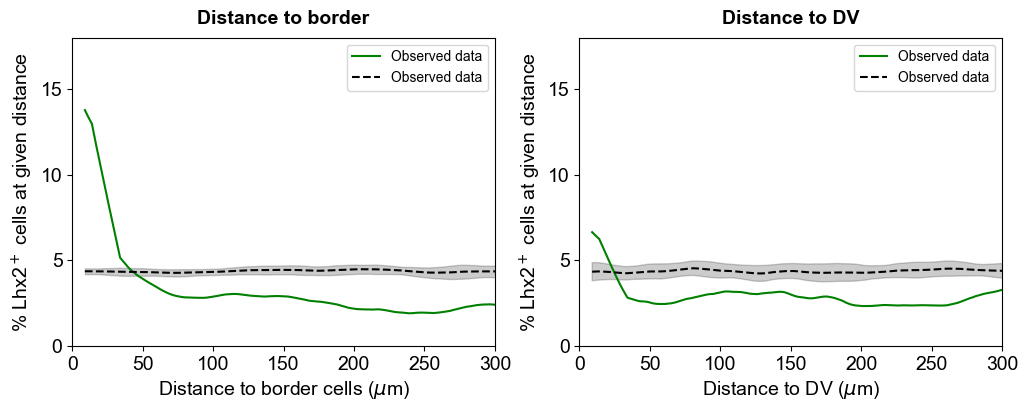

In [25]:
plt.rc('font',family='Arial')

fig, ax = plt.subplots(1, 2, figsize = (12,4))

ax1 = sns.lineplot(data = Lhx2_evo, x = 'r', y = 'mean_smooth', ax=ax[0], color = 'green', label = 'Observed data')

ax1 = sns.lineplot(data = Lhx2_evo_random,
                   x = 'r',
                   y = 'mean_smooth',
                   linestyle='--',
                   errorbar = 'sd',
                   label = 'Observed data',
                   ax=ax[0],
                   color = 'k')

ax2 = sns.lineplot(data = Lhx2_evo_vessel, x = 'r', y = 'mean_smooth', ax=ax[1], color = 'green', label = 'Observed data') 
ax2 = sns.lineplot(data = Lhx2_evo_vessel_random, 
                   x = 'r',
                   y = 'mean_smooth',
                   linestyle='--',
                   errorbar = 'sd',
                   label = 'Observed data',
                   ax=ax[1],
                   color = 'k')

for x in range(2):
    ax[x].set_ylim(0,18)
    ax[x].set_xlim(0,300)
    ax[x].tick_params(axis='y', labelsize=14, colors='k')
    ax[x].tick_params(axis='x', labelsize=14, colors='black')
    ax[x].set_ylabel('% Lhx2$^+$ cells at given distance', fontsize = 14, c = 'k')

ax1.set_xlabel('Distance to border cells ($\mu$m)', fontsize = 14)
ax2.set_xlabel('Distance to DV ($\mu$m)', fontsize = 14)

ax1.set_title('Distance to border', fontsize = 14, pad = 10, loc='center', weight='bold')
ax2.set_title('Distance to DV', fontsize = 14, pad = 10, loc='center', weight='bold')
plt.show()